# Internal Bar Strength
The [IBS](https://www.naaim.org/wp-content/uploads/2014/04/00V_Alexander_Pagonidis_The-IBS-Effect-Mean-Reversion-in-Equity-ETFs-1.pdf) indicator is (close-low)/(high-low).

Goal: **create, optimize and (paper) live trade** a multi-asset short-term mean-reversion system. We start with researching the IBS indicator. From the paper we know that it has worked until 2013, it would be interesting to see whether the results hold up an extra 10 years. From blogs I know it has held up for SPY, I wouldn't expect otherwise from other equity ETFs.

From the paper we know what is good for IBS:
* High range before
* Bear markets
* Mondays
* Works in almost all equity ETFs
* Lower IBS = higher returns

And what is bad:
* Fridays
* Low volume
* Local ETFs
* Shorts in low volatility
* If SPY is low, dont short international ETFs and vice versa

Rules of basic system:
* Universe: SPY and country ETFs
* Commissions: 2bps/trade. (SPY median spread is 0.3bps)
* Position size: 20% if multiple countries
* Entry rule: buy on close if IBS < 0.2 
* Exit: on next close

In [5]:
from datetime import datetime, date, time, timedelta
from times import get_market_dates, get_market_calendar, first_trading_date_after, last_trading_date_before
from data import get_data
from tickers import get_tickers, get_id
from portfolio import Portfolio
import performance
import json
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

DATA_PATH = "../data/polygon/"
START_DATE = first_trading_date_after(date(2003, 9, 10))
END_DATE = last_trading_date_before(date(2024, 3, 1))

calendar = get_market_calendar("datetime")
list_ETFs = ['SPY', 'EWA', 'EWO', 'EWK', 'EWC', 'EWQ', 'EWG', 'EWH', 'EWI', 'EWJ', \
    'EWM', 'EWW', 'EWN', 'EWS', 'EWP', 'EWD', 'EWL', 'EWU']

In [6]:
data = {}

for ticker in list_ETFs:
    id = get_id(ticker)
    data[ticker] = get_data(ticker_or_id=id, 
                            start_date=START_DATE, 
                            end_date=END_DATE, 
                            timeframe='daily',
                            columns=['open', 'high', 'low', 'close', 'turnover'])

### Testing on SPY

In [10]:
portfolio = Portfolio(datetime.combine(START_DATE - timedelta(days=1), time(0)), data, initial_capital=10000)

for day in get_market_dates(START_DATE, END_DATE):
    today_close_dt = calendar.at[day, 'regular_close']
    day_dt = datetime.combine(day, time(0)) # Because daily bars always have 00:00 time. This is just a convention.
    
    close = data['SPY'].at[day_dt, 'close']
    low = data['SPY'].at[day_dt, 'low']
    high = data['SPY'].at[day_dt, 'high']
    IBS = (close-low)/(high-low)

    qty = int(portfolio.current_cash/close)

    if IBS < 0.2 and portfolio.current_positions.get('SPY', 0) == 0:
        portfolio.update_from_fill(
            dt=today_close_dt,
            side="BUY",
            symbol='SPY',
            fill_quantity=qty,
            fill_price=close,
            fees=close*0.0002*abs(qty),
        )
    
    elif portfolio.current_positions.get('SPY', 0) > 0:
        qty = portfolio.current_positions.get('SPY', 0)
        portfolio.update_from_fill(
            dt=today_close_dt,
            side="SELL",
            symbol='SPY',
            fill_quantity=qty,
            fill_price=close,
            fees=close*0.0002*abs(qty),
        )

    portfolio.append_portfolio_log(day_dt)

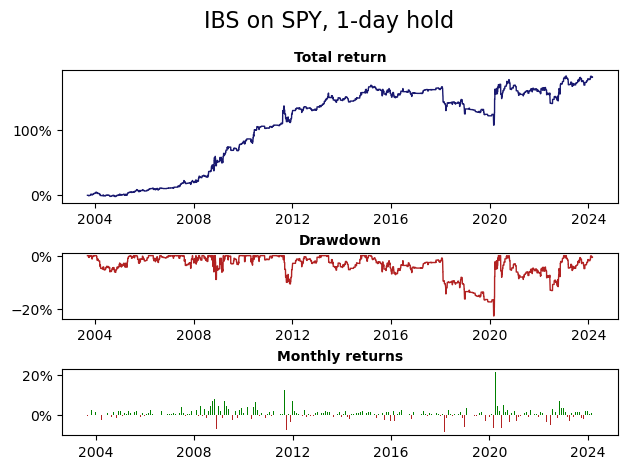

In [11]:
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = performance.fills_to_trades_no_partials(fills_log)

performance.plot_fig(portfolio_log, title='IBS on SPY, 1-day hold')

In [12]:
performance.display_stats_and_returns(portfolio_log, fills_log, trade_log)

,Stats
Annual return,5.2%
Sharpe,0.58
Sortina,0.49
Winning months,58.0%
Time in market,16.0%
Average profit,0.14%
Average duration per trade,"1d, 10.5h"
Profit factor,1.04
Trades/month,2.3
Annual fees,1.6%


### Testing on all country ETFs

In [15]:
portfolio = Portfolio(datetime.combine(START_DATE - timedelta(days=1), time(0)), data, initial_capital=10000)

for day in get_market_dates(START_DATE, END_DATE):
    today_close_dt = calendar.at[day, 'regular_close']
    day_dt = datetime.combine(day, time(0)) # Because daily bars always have 00:00 time. This is just a convention.
    
    for ticker in list_ETFs:
        try:
            data[ticker].at[day_dt, 'close']
        except KeyError:
            continue

        close = data[ticker].at[day_dt, 'close']
        low = data[ticker].at[day_dt, 'low']
        high = data[ticker].at[day_dt, 'high']
        if high-low == 0:
            IBS = 0.5
        else:
            IBS = (close-low)/(high-low)

        qty = int(portfolio._current_equity * 0.2/close)

        # Logic changed because it should be possible to re-entry.
        if portfolio.current_positions.get(ticker, 0) > 0:
            qty = portfolio.current_positions.get(ticker, 0)
            portfolio.update_from_fill(
                dt=today_close_dt,
                side="SELL",
                symbol=ticker,
                fill_quantity=qty,
                fill_price=close,
                fees=close*0.0002*abs(qty),
            )

        if IBS < 0.2 and portfolio.current_positions.get(ticker, 0) == 0:
            portfolio.update_from_fill(
                dt=today_close_dt,
                side="BUY",
                symbol=ticker,
                fill_quantity=qty,
                fill_price=close,
                fees=close*0.0002*abs(qty),
            )

    portfolio.append_portfolio_log(day_dt)

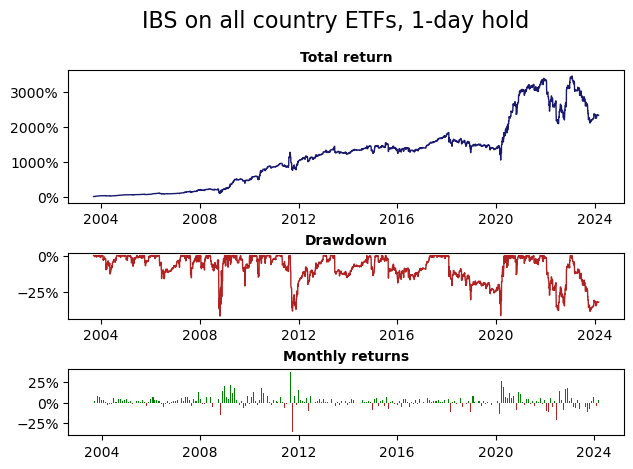

In [26]:
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = performance.fills_to_trades_no_partials(fills_log)

performance.plot_fig(portfolio_log, title='IBS on all country ETFs, 1-day hold')

In [27]:
performance.display_stats_and_returns(portfolio_log, fills_log, trade_log)

,Stats
Annual return,16.9%
Sharpe,0.65
Sortina,0.77
Winning months,65.0%
Time in market,58.0%
Average profit,0.13%
Average duration per trade,"1d, 9.6h"
Profit factor,1.05
Trades/month,42.1
Annual fees,5.8%


Because the bear-market performance is very good, I will continue to analyze and optimize the system. This unoptimized systme also trades 55 times per month, which is a lot.

### Parameter analysis
What is the effect of the IBS on the next-day return?

In [28]:
portfolio = Portfolio(datetime.combine(START_DATE - timedelta(days=1), time(0)), data, initial_capital=10000)

for day in get_market_dates(START_DATE, END_DATE):
    today_close_dt = calendar.at[day, 'regular_close']
    day_dt = datetime.combine(day, time(0)) # Because daily bars always have 00:00 time. This is just a convention.
    
    close = data['SPY'].at[day_dt, 'close']
    low = data['SPY'].at[day_dt, 'low']
    high = data['SPY'].at[day_dt, 'high']
    IBS = (close-low)/(high-low)

    qty = int(portfolio.current_cash/close)
    
    if portfolio.current_positions.get('SPY', 0) > 0:
        qty = portfolio.current_positions.get('SPY', 0)
        portfolio.update_from_fill(
            dt=today_close_dt,
            side="SELL",
            symbol='SPY',
            fill_quantity=qty,
            fill_price=close,
            fees=close*0.00005*abs(qty),
        )
        
    portfolio.update_from_fill(
        dt=today_close_dt,
        side="BUY",
        symbol='SPY',
        fill_quantity=qty,
        fill_price=close,
        fees=close*0.00005*abs(qty),
    )


    portfolio.append_portfolio_log(day_dt)

In [29]:
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = performance.fills_to_trades_no_partials(fills_log)

trade_log = trade_log.drop(columns=['remaining_qty', 'net P/L $', 'fees'])
trade_log.to_csv('../output/trade_log_IBS_analysis.csv')

In [30]:
trade_log = pd.read_csv('../output/trade_log_IBS_analysis.csv', parse_dates=['datetime_in', 'datetime_out'], index_col=0)
calendar = get_market_calendar("datetime")

trade_log['IBS'] = pd.Series(dtype='float')

In [31]:
for index, row in trade_log.iterrows():
    day = row['datetime_in'].date()
    day_dt = datetime.combine(day, time(0)) # Because daily bars always have 00:00 time. This is just a convention.
    
    close = data['SPY'].at[day_dt, 'close']
    low = data['SPY'].at[day_dt, 'low']
    high = data['SPY'].at[day_dt, 'high']
    IBS = (close-low)/(high-low)

    trade_log.at[index, 'IBS'] = IBS

trade_log['IBS'] = round(trade_log['IBS'], 2)


trade_log.to_csv('../output/trade_log_IBS_analysis.csv')

In [32]:
trade_log = pd.read_csv('../output/trade_log_IBS_analysis.csv', parse_dates=['datetime_in', 'datetime_out'], index_col=0)

### Distribution of the IBS

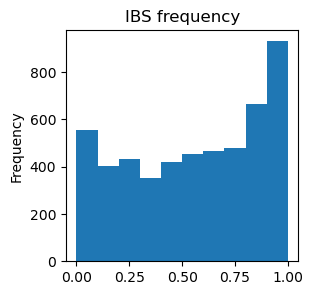

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3));
plt.hist(trade_log.IBS, bins=10)
plt.gca().set(title='IBS frequency', ylabel='Frequency');


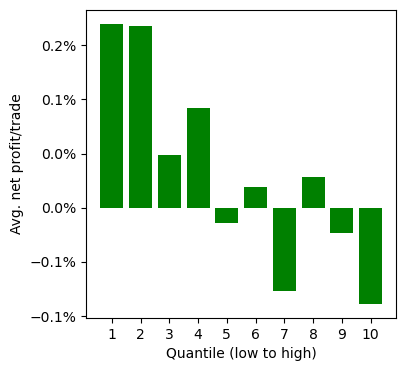

In [34]:
performance.plot_quintiles(trade_log, 'IBS', bins=10)

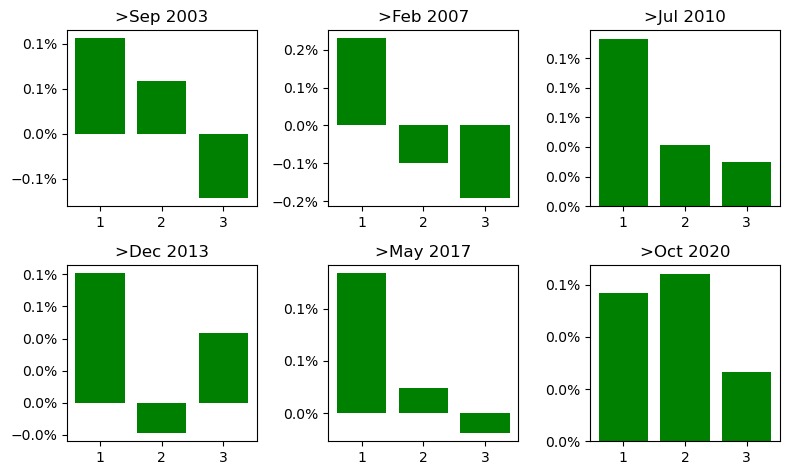

In [35]:
performance.plot_quantiles_periods(trade_log, 'IBS', bins=3)

### Other markets